In [88]:
#!pip install econml

In [89]:
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

metrics

In [90]:
def abs_ate(effect_true, effect_pred):
    
    ate = np.mean(effect_true)
    ate_hat = np.mean(effect_pred)
    epsilon = abs(ate_hat-ate)
    return epsilon

In [91]:
def pehe(effect_true, effect_pred):
    
    epsilon = np.sqrt(sum((effect_pred-effect_true)**2)*(1/len(effect_pred)))
    return epsilon
    

data

In [92]:
# pip install wget
import wget

In [93]:
wget.download("https://github.com/dmachlanski/CE888_2022/raw/main/lab4/data/sodium_10k.npz")

100% [............................................................................] 320962 / 320962

'sodium_10k (4).npz'

In [94]:
data = np.load('sodium_10k.npz')

In [95]:
data.files

['x', 't', 'y', 'ite']

In [96]:
for f in data.files:
    print(f'{f}: {data[f].shape}')

x: (10000,)
t: (10000,)
y: (10000,)
ite: (10000,)


In [97]:
X = data['x'].reshape(-1, 1)
T = data['t'].reshape(-1, 1)
Y = data['y'].reshape(-1, 1)
ite = data['ite']

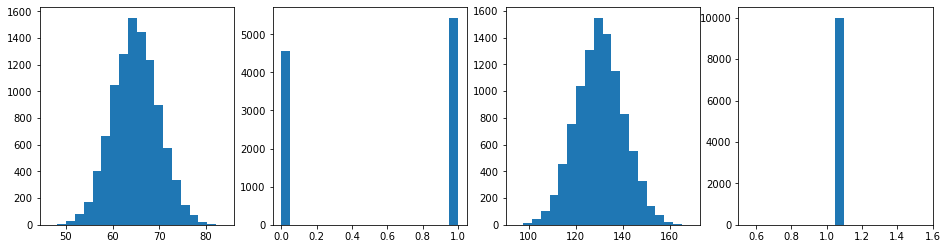

In [98]:
bins=20
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].hist(X, bins=bins)
axs[1].hist(T, bins=bins)
axs[2].hist(Y, bins=bins)
axs[3].hist(ite, bins=bins)
plt.show()

In [99]:
#we know the ATE is 1.05, so np.mean(ite)


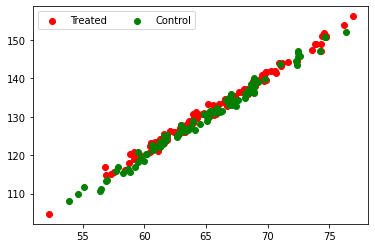

In [100]:
limit = 100
plt.scatter(X[T == 1][:limit], Y[T == 1][:limit], c = "r", label = "Treated")
plt.scatter(X[T == 0][:limit], Y[T == 0][:limit], c = "g", label = "Control")
plt.legend(ncol=2)

data pre-processing

In [101]:
x_train, x_test, t_train, t_test, y_train, y_test, ite_train, ite_test = train_test_split(X, T, Y, ite, test_size=0.2)

scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

training

     Random Forest

In [102]:
rf=RandomForestRegressor()
#Train on the training data,in supetrvised data our x consists of x and t,input :[x,t] and target(output): Y
xt_train= np.concatenate([x_train, t_train], axis=1)
rf.fit(xt_train, y_train.flatten())

RandomForestRegressor()

In [103]:
#prediction p(Y|X, do(T=t))

xt0_test= np.concatenate([x_test, np.zeros_like(t_test)], axis=1)
rf_y0_test= rf.predict(xt0_test)

xt1_test= np.concatenate([x_test, np.ones_like(t_test)], axis=1)
rf_y1_test=rf.predict(xt1_test)



In [104]:
#ITE=Y_1 - Y_0
rf_ite_test = rf_y1_test - rf_y0_test

   Random Forest with IPW

In [105]:
#IPW=Inverse Propensity Weighting
#this is classic binary classification
#P(ti|xi) is called propensity score
#wi=ti/P(ti|xi) + (1-ti)/(1-P(ti|xi))
def get_ps_weights(clf, x, t):
    ti = np.squeeze(t)
    clf.fit(x, ti)
    ptx = clf.predict_proba(x).T[1].T + 0.0001 # add a small value to avoid dividing by 0
  # Given ti and ptx values, compute the weights wi (see formula above):
    wi = (ti/ptx) + ((1-ti)/(1-ptx))
    return wi

In [106]:
# Get the sample weights
prop_clf = RandomForestClassifier()
weights = get_ps_weights(prop_clf, x_train, t_train)

# Train the regressor
rf_ipsw = RandomForestRegressor()

rf_ipsw.fit(xt_train, y_train.flatten(), sample_weight= weights)

# Make predictions
rf_ipsw_y0_test = rf.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
rf_ipsw_y1_test = rf.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

# Compute ITE
rf_ipsw_ite_test = rf_ipsw_y1_test - rf_ipsw_y0_test 

      X-Learner

In [107]:
#just this 3 line code:)
xL=XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
xL.fit(y_train, t_train.flatten(), X=x_train)

xL_ite_test= xL.effect(x_test)

evaluation

In [108]:
# Error on ATE
# Use our 'abs_ate' function, true ITEs and predicted ITEs to get the measurements.
rf_ate_test =abs_ate(x_test, rf_ite_test) 
rf_ipsw_ate_test =abs_ate(x_test, rf_ipsw_ite_test) 
xl_ate_test =abs_ate(x_test, xL_ite_test) 

# PEHE
# Use our 'pehe' function, true ITEs and predicted ITEs to get the measurements.
rf_pehe_test = pehe(x_test, rf_ite_test)
rf_ipsw_pehe_test = pehe(x_test, rf_ipsw_ite_test)
xl_pehe_test = pehe(x_test, xL_ite_test)

In [109]:
results = []
results.append(['RF', rf_ate_test, rf_pehe_test])
results.append(['RF (IPW)', rf_ipsw_ate_test, rf_ipsw_pehe_test])
results.append(['XL', xl_ate_test, xl_pehe_test])

cols = ['Method', 'ATE test', 'PEHE test']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE test,PEHE test
0,RF,1.004640,"[1.0357401231567902, 1.4543395965139776, 0.995..."
1,RF (IPW),1.004640,"[1.0357401231567902, 1.4543395965139776, 0.995..."
2,XL,1.027376,[1.6704144523523272]


Confidence intervals

In [110]:
def mean_ci(data, ci=0.95):
    l_mean = np.mean(data)
    lower, upper = st.t.interval(ci, len(data)-1, loc=l_mean, scale=st.sem(data))
    return l_mean, lower, upper

In [111]:
rf_ate_bounds = mean_ci(rf_ite_test)
rf_ipsw_ate_bounds = mean_ci(rf_ipsw_ite_test)
xl_ate_bounds = mean_ci(xL_ite_test)

results = []
results.append(['RF', rf_ate_bounds[0], rf_ate_bounds[1], rf_ate_bounds[2]])
results.append(['RF (IPW)', rf_ipsw_ate_bounds[0], rf_ipsw_ate_bounds[1], rf_ipsw_ate_bounds[2]])
results.append(['XL', xl_ate_bounds[0], xl_ate_bounds[1], xl_ate_bounds[2]])

cols = ['Method', 'ATE mean', 'CI lower', 'CI upper']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE mean,CI lower,CI upper
0,RF,1.019000,0.977027,1.06097
1,RF (IPW),1.019000,0.977027,1.06097
2,XL,1.041736,[1.0030653418539959],[1.0804063699152973]


Visualisations

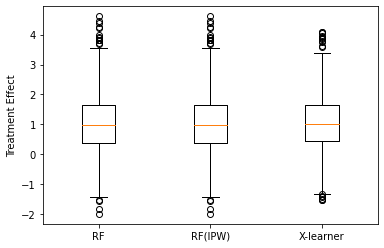

In [112]:
plt.figure()
plt.boxplot([rf_ite_test, rf_ipsw_ite_test, xL_ite_test.flatten()], labels=["RF", "RF(IPW)", "X-learner"])
plt.ylabel("Treatment Effect")
plt.show()

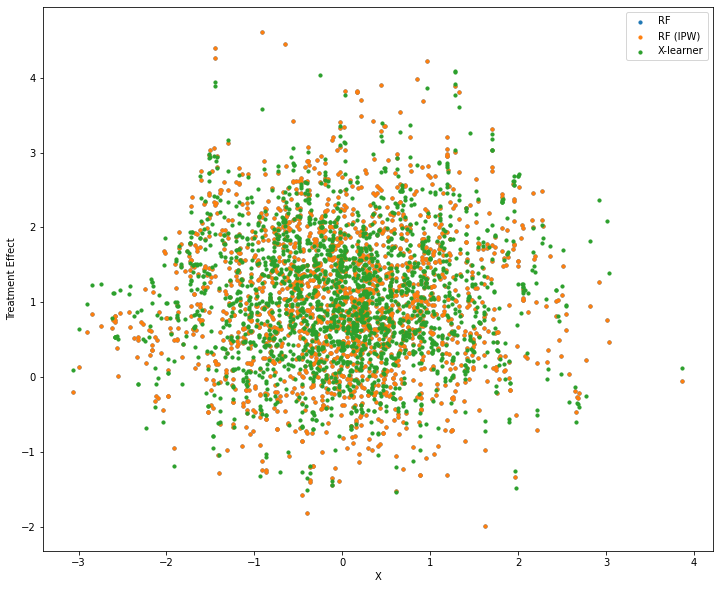

In [113]:
plt.figure(figsize=(12, 10))
m_size = 10
plt.scatter(x_test, rf_ite_test, label="RF", s=m_size)
plt.scatter(x_test, rf_ipsw_ite_test, label="RF (IPW)", s=m_size)
plt.scatter(x_test, xL_ite_test, label="X-learner", s=m_size)
plt.xlabel('X')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

 Heterogeneous effect

In [114]:
#1) 
#problem setting:
#hte_generate.py similary to the pervious dataset
#triangel
#effect T on Y and X effects on both covariates

#2)
#Metrics: 
#same metrics as before (epcilonATE and epsPEHE)


In [115]:
#3) load the dataset

# 1. Load hte_train.csv from: https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/lab4/data/hte_train.csv
# 2. Load hte_test.csv from: https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/lab4/data/hte_test.csv
df_hte_train = pd.read_csv('https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/lab4/data/hte_train.csv')
df_hte_test = pd.read_csv('https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/lab4/data/hte_test.csv')
print(df_hte_train.shape, df_hte_test.shape)


(29, 4) (20, 4)


In [116]:
#explore the data like before with sodium ,make histageram and scatter plots ,...

In [117]:
df_hte_train.head()

,x,t,y,ite
0,0.023976,1.0,2.429799,2.3
1,-0.094244,1.0,2.363082,2.3
2,-0.020031,1.0,2.572256,2.3
3,0.006930,1.0,2.605929,2.3
4,1.156410,1.0,0.346002,-3.7


In [118]:
df_hte_test.head()

,x,t,y,ite
0,0.012826,1.0,2.492201,2.3
1,0.041816,1.0,2.388398,2.3
2,-0.096298,1.0,2.568154,2.3
3,-0.027440,1.0,2.649401,2.3
4,0.063349,1.0,2.514691,2.3


In [119]:
# Scatter plots - feel free to reuse the code from the sodium example.
# Hint: use DataFrame.loc to access treated and control units, or store the columns as numpy arrays.

x_train = df_hte_train['x'].values.reshape(-1, 1)
t_train = df_hte_train['t'].values.reshape(-1, 1)
y_train = df_hte_train['y'].values.reshape(-1, 1)
ite_train = df_hte_train['ite']


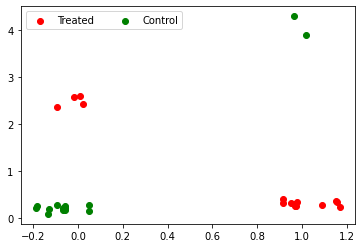

In [120]:
limit = 100
plt.scatter(x_train[t_train == 1][:limit], y_train[t_train == 1][:limit], c = "r", label = "Treated")
plt.scatter(x_train[t_train == 0][:limit], y_train[t_train == 0][:limit], c = "g", label = "Control")
plt.legend(ncol=2)

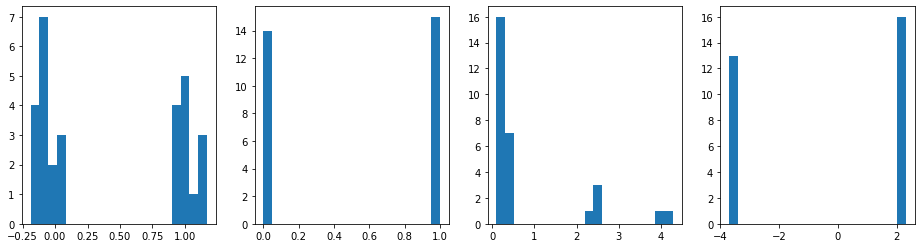

In [121]:
# Histograms - again, feel free to reuse the pre-existing code.

# YOUR CODE HERE
bins=20
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].hist(x_train, bins=bins)
axs[1].hist(t_train, bins=bins)
axs[2].hist(y_train, bins=bins)
axs[3].hist(ite_train, bins=bins)
plt.show()

In [122]:
#4) Data pre-processing:
#There is little (if any) data pre-processing necessary here. The dataset is already divided into training and testing. 
#The only part left is scaling, depending on the type of models you plan to use.

x_test = df_hte_test['x'].values.reshape(-1, 1)
t_test = df_hte_test['t'].values.reshape(-1, 1)
y_test = df_hte_test['y'].values.reshape(-1, 1)
ite_test = df_hte_test['ite']

scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

In [123]:
#5) Training
#This is the modelling part. You should have the following types of models:
#Regressor (scikit-learn) & Weighted regressor (IPW, scikit-learn) & CATE estimator from EconML
#For each of the above types, choose the models you like - it is up to you!

#Steps:
  #1-Train the models on training data.
  #2-Predict outcomes and calculate effects, or predict effects directly, depending on the method used, on test data.


Random forest

In [124]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [125]:
random= RandomForestRegressor()

xt_train= np.concatenate([x_train, t_train], axis=1)
random.fit(xt_train, y_train.flatten())

RandomForestRegressor()

In [126]:
#prediction 
xt0_test=np.concatenate([x_test, np.zeros_like(t_test)], axis=1)
random_y0_test= random.predict(xt0_test)

xt1_test=np.concatenate([x_test, np.ones_like(t_test)], axis=1)
random_y1_test= random.predict(xt1_test)

#ITE
random_ite_test= random_y1_test - random_y0_test


Random forest with IPW

In [127]:
# Get the sample weights
prop_random= RandomForestClassifier()
weights= get_ps_weights(prop_random, x_train, t_train)


# Train the regressor
random_ipsw= RandomForestRegressor()
random_ipsw.fit(xt_train, y_train.flatten(), sample_weight= weights)

# Make predictions
random_ipsw_y0_test= random_ipsw.predict(xt0_test)
random_ipsw_y1_test= random_ipsw.predict(xt1_test)

#ITE
random_ipsw_ite_test= random_ipsw_y1_test - random_ipsw_y0_test

X-learner

In [128]:
XL= XLearner(models= RandomForestRegressor(), propensity_model=RandomForestClassifier())
XL.fit(y_train, t_train.flatten(), X=x_train)

#ITE
XL_ite_test= XL.effect(x_test)

In [129]:
#6) Evaluation

#Here, use both metrics(epsATE & epsPEHE)to evaluate the performance of your models.
#Feel free to perform any other form of evaluation as we did before (confidence intervals, box plots, etc.).

In [131]:
# Evaluate your predictions with 'abs_ate' and 'pehe' functions

#Error on ATE
random_ate_test= abs_ate(x_test,random_ite_test)
random_ipsw_ate_test= abs_ate(x_test,random_ipsw_ite_test)
XL_ate_test= abs_ate(x_test,XL_ite_test)

#Error on PEHE
random_pehe_test= pehe(x_test, random_ite_test)
random_ipsw_pehe_test= pehe(x_test, random_ipsw_ite_test)
XL_pehe_test= pehe(x_test, XL_ite_test)


In [132]:
results = []
results.append(['RF', random_ate_test, random_pehe_test])
results.append(['RF (IPW)', random_ipsw_ate_test, random_ipsw_pehe_test])
results.append(['XL', XL_ate_test, XL_pehe_test])

cols = ['Method', 'ATE test', 'PEHE test']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE test,PEHE test
0,RF,0.542021,"[1.6615997667782914, 1.5230418398154668, 1.613..."
1,RF (IPW),0.259183,"[1.9087373520367092, 1.7750136816308846, 1.518..."
2,XL,0.682915,[3.788999710232196]


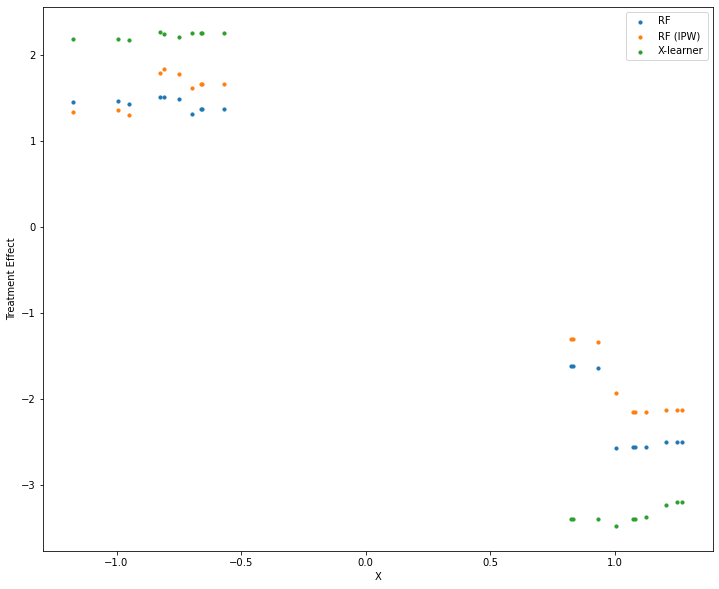

In [135]:
plt.figure(figsize=(12, 10))
m_size = 10
plt.scatter(x_test, random_ite_test, label="RF", s=m_size)
plt.scatter(x_test, random_ipsw_ite_test, label="RF (IPW)", s=m_size)
plt.scatter(x_test, XL_ite_test, label="X-learner", s=m_size)
plt.xlabel('X')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

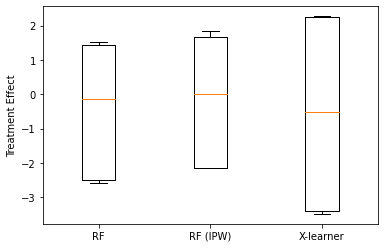

In [134]:
plt.figure()
plt.boxplot([random_ite_test, random_ipsw_ite_test, XL_ite_test.flatten()], labels=['RF', 'RF (IPW)', 'X-learner'])
plt.ylabel('Treatment Effect')

plt.show()